---
### Conflict on Wikipedia

In this report, I analyzed reverts on Wikipedia. A revert occurs when an editor undoes the changes made by another editor. I identified who reverted whom and when, the situations in which if $A$ reverted $B$, $B$ reverted $A$ within 24 hours, and finally, studied the difference in seniority between $A$ and $B$.

### Data

The data is from the  `rowiki_2006.txt` file in this folder. It is originally from the Wikipedia XML Dumps (https://dumps.wikimedia.org/mirrors.html) and includes every article edit made on Romanian Wikipedia since it began until the end of 2006. Each line in the file is an edit and includes the title of the edited article, the time when the edit was submitted, whether the edit was a revert, the version of the article, and the user who submitted the edit. To detect the article versions, a hash was calculated for the complete article text following each revision and the hashes were compared between edits. 

The table below describes the variables in the data:

| Variable   | Explanation   
|:-----------|:-------
| title      | title of the edited article               
| time       | time in the format YYYY-MM-DD HH:MM:SS when the edit was completed  
| revert     | 1 if the edit was detected to revert to a previous article version, 0 otherwise 
| version    | an integer indicating a unique state of the article, generally increasing over time; -1 indicates the article was empty (usually due to vandalism); if the same number appears more than once, then the article was exactly in the same state at these different time points  
| user       | the editor's username or if not logged in, the editor's IP address  


### 1. Identifying Who reverted Whom

I created a network, where an edge goes from the editor who restored an earlier version of the article (the "reverter") to the editor who made the revision immediately after that version (the "reverted"). For every edge, I stored information on who the reverter was, who got reverted, when the revert occurred, and what the "seniority" of the the reverter and the reverted were at this point in time. I ignored articles titles and self-reverts

I estimated seniority $s_i$ of editor $i$ as the base-ten logarithm of the number of edits $i$ has completed by the time of the revert under question. Transforming the number of edits with the logarithm makes sense because they follow a power-law distribution (the majority of individuals have very few edits, while a handful of individuals are responsible for most of the work). This operationalization allows to express the difference in seniority between two editors as the base-ten logarithm of the ratio of number of edits since $s_i - s_j = \log_{10} e_i - \log_{10} e_j = \log_{10} \frac{e_i}{e_j}$, where $e_i$ is the number of edits of editor $i$ and $e_j$ is the number of edits of editor $j$. In essence, we assume that an editor who has 10 edits compares to one with 100 edits the same way that an editor with 1,000 edits compares to one with 10,000.

In [3]:
import numpy as np
from data_processing import parse_content, process_edit_data, find_revert_data, process_all_revert_data
from seniority_processing import get_non_ab_ba_seniorities
from visualization import plot_seniority, print_network_data
import pickle

TIME_INDEX = 0
REVERT_INDEX = 1
VERSION_INDEX = 2

In [ ]:
# Get content from file
file_path = 'rowiki_2006.txt'
content = parse_content(file_path)

# Get all potential reverts
potential_reverts = [entry for entry in content if entry[REVERT_INDEX] == '1']

# Sort content to get edit data to calculate seniority at any given time
content_sorted = sorted(content, key=lambda x: x[TIME_INDEX])
edit_dic = process_edit_data(content_sorted)

# Calculate max number of versions of any article
max_num_versions = max(content, key=lambda x: x[VERSION_INDEX])[VERSION_INDEX]

# Get revert data
revert_data = find_revert_data(content, potential_reverts, edit_dic, max_num_versions)

# Pickle revert data
with open ('revert_data_dict', 'wb') as fw:
    pickle.dump(revert_data, fw)

In [4]:
# Unpickle saved Python object
with open ('revert_data_dict', 'rb') as fr:
    revert_data_retreived = pickle.load(fr)

print_network_data(revert_data_retreived)

The first 5 data points are:
Thijs!bot:
	{'reverted': 'RobotQuistnix', 'time': datetime.datetime(2006, 8, 27, 0, 39, 41), 'seniority_reverter': 3.4281347940287885, 'seniority_reverted': 4.452185250814898}
	{'reverted': '85.218.30.107', 'time': datetime.datetime(2006, 10, 20, 14, 22, 18), 'seniority_reverter': 3.972202838379064, 'seniority_reverted': 0.0}
	{'reverted': '85.167.177.24', 'time': datetime.datetime(2006, 11, 30, 4, 55, 22), 'seniority_reverter': 4.202161247019353, 'seniority_reverted': 0.0}
	{'reverted': 'Alvac', 'time': datetime.datetime(2006, 12, 12, 21, 15, 25), 'seniority_reverter': 4.226909084965482, 'seniority_reverted': 1.462397997898956}
	{'reverted': 'Alvac', 'time': datetime.datetime(2006, 12, 12, 21, 4, 44), 'seniority_reverter': 4.226548353841411, 'seniority_reverted': 1.3424226808222062}

The number of nodes in the network are: 4805
The number of edges in the network are: 7364


### 2. If $A$ reverted $B$, did $B$ revert $A$?

The aim is to identify the two-event sequence in which after $A$ reverts $B$, $B$ reverts $A$ back ($AB–BA$) within 24 hours. To identify these sequences, use the revert data from the previous task. We will ignore the article titles — we are agnostic as to whether the response happens in the same or in different articles. Further, it does not matter whether the response occurs immediately after the original revert or alternatively, the reverter and the reverted are involved in other reverts in-between the original revert and the response. If more than one response occurs within 24 hours, consider only the first one as part of the event sequence.

When you identify an AB–BA event sequence, save information about the edges that allows you to identify them later. 

**Print the number of AB–BA event sequences in the data.**

In [5]:
# Get seniorities differences for all ab-ba sequences and a list of all considered reverts
ab_ba_seniorities, considered_reverts = process_all_revert_data(revert_data_retreived)

print("The number of ab-ba sequences are: " + str(len(ab_ba_seniorities)))

The number of ab-ba sequences are: 185


### 3. Are $A$ and $B$ more similar in seniority than expected?

Social comparison theory states that people strive to gain accurate self-evaluations and as a result, they tend to compare themselves to those who are similar. But since focus on relative performance heightens feelings of competitiveness, rivalry is stronger among similar individuals. This leads us to expect that the editors involved in the $AB–BA$ event sequences tend to be closer in seniority than expected.

To find evidence that retaliation is more likely among similar individuals, we will compare the *absolute difference* in seniority between editors involved in $AB–BA$ event sequences with the absolute difference in seniority between editors involved in any other revert (all the reverts in the data that are not part of the AB–BA sequences).

First, **plot a histogram** of $|s_A - s_B|$ for reverts that are part of $AB–BA$ motifs on top of a histogram of $|s_i - s_j|$ for all other reverts. 

Then, **print the mean $|s_A - s_B|$ and the mean $|s_i - s_j|$**.


The mean for reverts that are a part of AB-BA motifs is 2.2014825685345016
The mean for all other reverts is 2.60955573041775


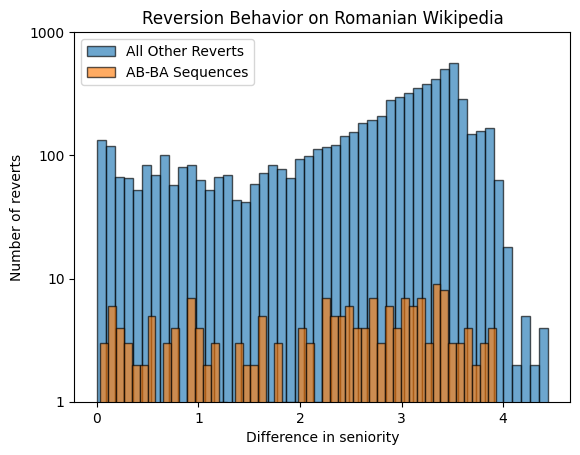

In [6]:
# Get seniority differences for all other reverts
non_ab_ba_seniorities = get_non_ab_ba_seniorities(revert_data_retreived, considered_reverts)

# Plot seniorities for ab-ba sequences and all other reverts
plot_seniority(non_ab_ba_seniorities, ab_ba_seniorities)

print("The mean for reverts that are a part of AB-BA motifs is " + str(np.mean(ab_ba_seniorities)))
print("The mean for all other reverts is " + str(np.mean(non_ab_ba_seniorities)))